<a href="https://colab.research.google.com/github/Ash2809/Road-Landmark-Detection/blob/main/Lane_Detection_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

def load_data(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (256, 256)) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask > 127, tf.float32)

    return image, mask

def data_pipeline(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [2]:
from tensorflow.keras import layers, Model

def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [3]:
import os

def get_file_paths(directory):
    """
    Returns a sorted list of file paths in the given directory.
    Assumes that images and masks are named correspondingly.
    """
    return sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.png', '.jpeg'))])

train_image_paths = get_file_paths(r"/content/drive/MyDrive/Dataset/train/images")
train_mask_paths = get_file_paths(r"/content/drive/MyDrive/Dataset/train/masks")
val_image_paths = get_file_paths(r"/content/drive/MyDrive/Dataset/val/images")
val_mask_paths = get_file_paths(r"/content/drive/MyDrive/Dataset/val/masks")

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")

Number of training images: 2538
Number of training masks: 2538
Number of validation images: 544
Number of validation masks: 544


In [4]:
train_dataset = data_pipeline(train_image_paths, train_mask_paths, batch_size=16)
val_dataset = data_pipeline(val_image_paths, val_mask_paths, batch_size=16)

In [5]:
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)


Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


In [6]:
h = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 1363s 8s/step - accuracy: 0.9284 - loss: 0.2482 - val_accuracy: 0.9571 - val_loss: 0.1588
Epoch 2/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 125s 519ms/step - accuracy: 0.9570 - loss: 0.1573 - val_accuracy: 0.9571 - val_loss: 0.1581
Epoch 3/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 139s 498ms/step - accuracy: 0.9570 - loss: 0.1521 - val_accuracy: 0.9574 - val_loss: 0.1512
Epoch 4/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 508ms/step - accuracy: 0.9574 - loss: 0.1468 - val_accuracy: 0.9578 - val_loss: 0.1558
Epoch 5/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 85s 528ms/step - accuracy: 0.9576 - loss: 0.1480 - val_accuracy: 0.9578 - val_loss: 0.1522
Epoch 6/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 137s 498ms/step - accuracy: 0.9581 - loss: 0.1442 - val_accuracy: 0.9580 - val_loss: 0.1509
Epoch 7/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 86s 523ms/step - accuracy: 0.9581 - loss: 0.1406 - val_accuracy: 0.9589 - val_loss: 0.1421
Epoch 8/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 139s 503ms/step - accuracy: 0.9586 - loss

In [7]:
model.save('LD.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


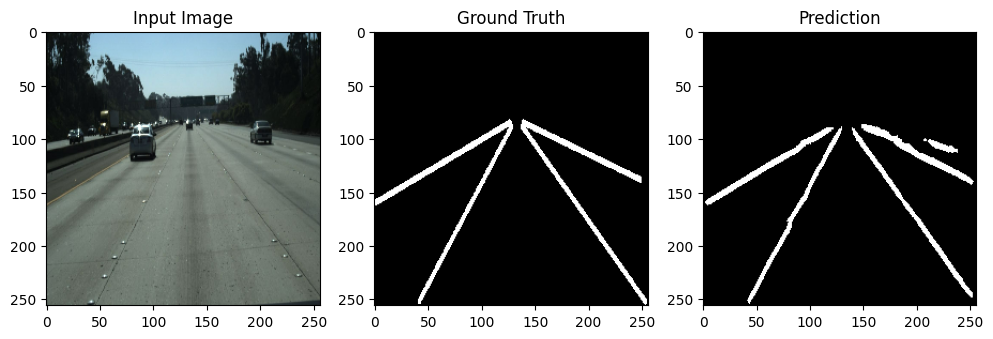

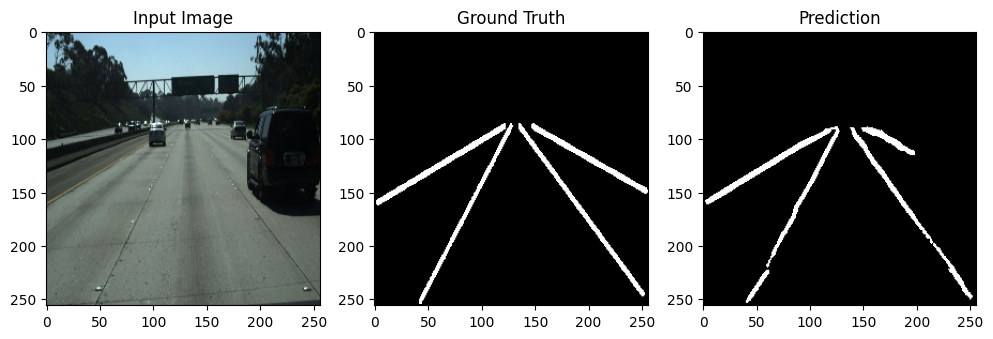

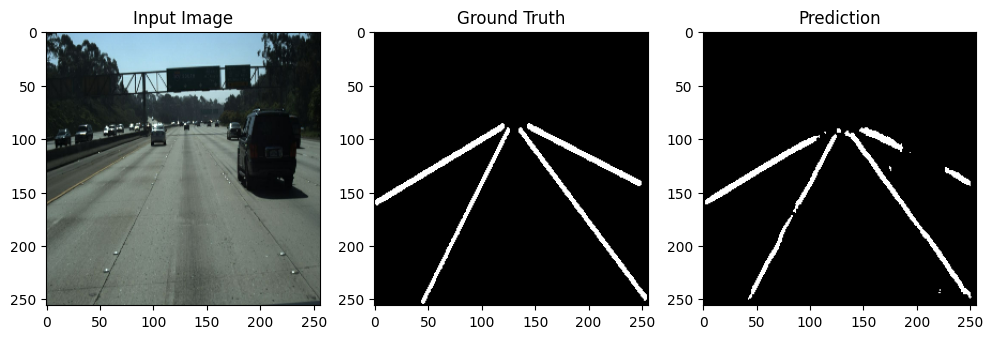

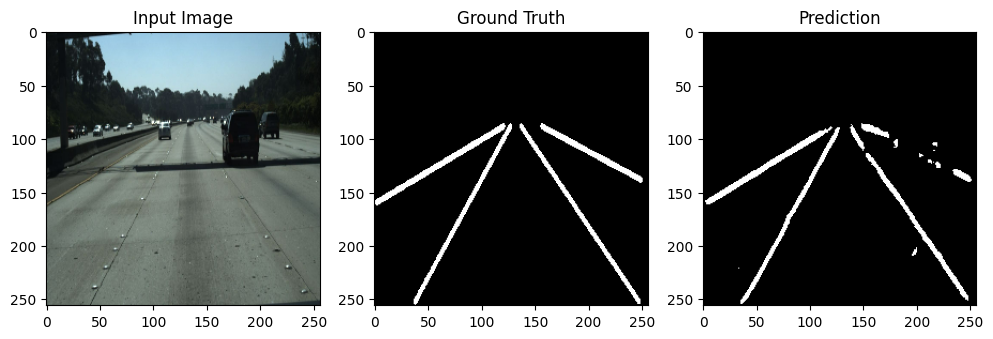

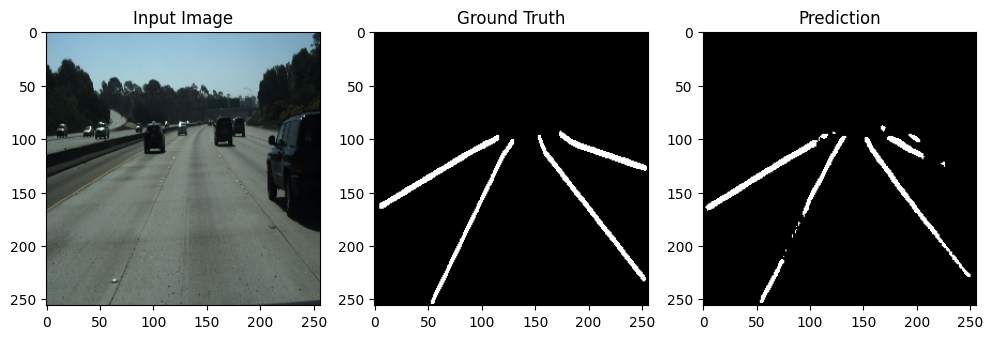

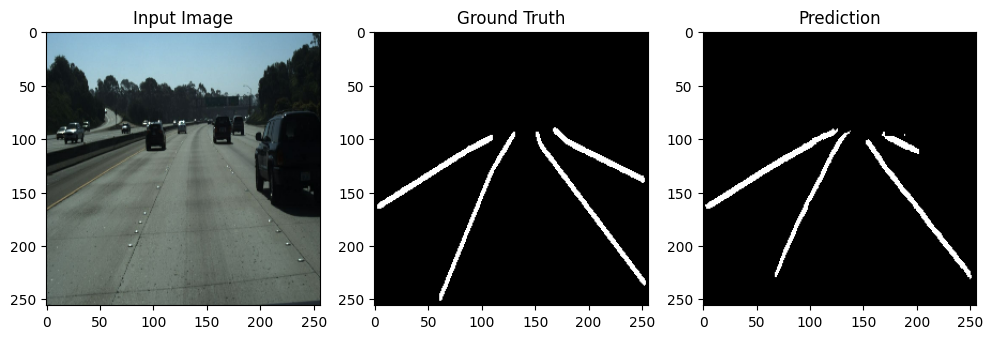

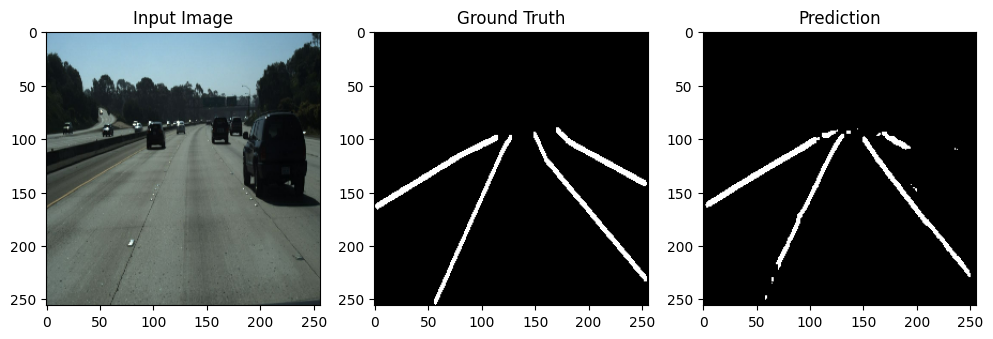

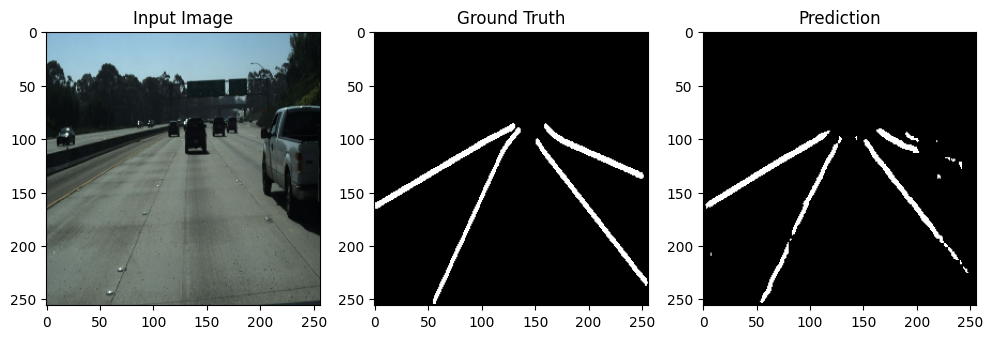

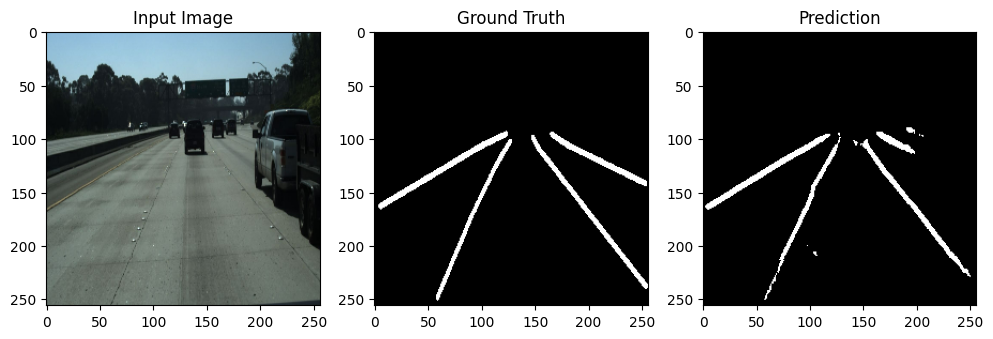

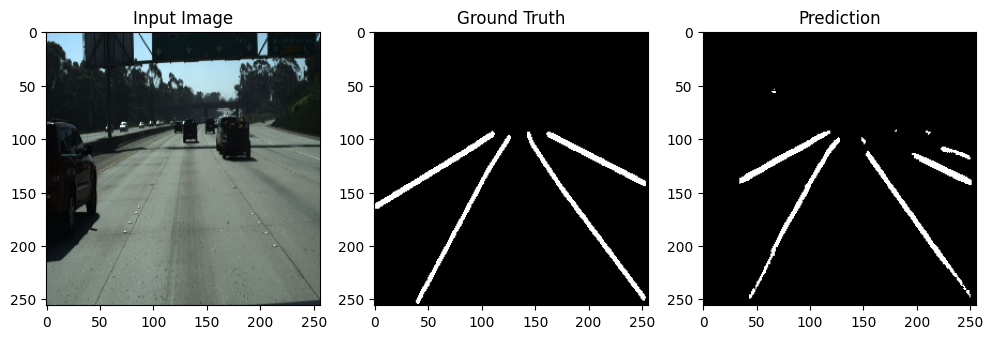

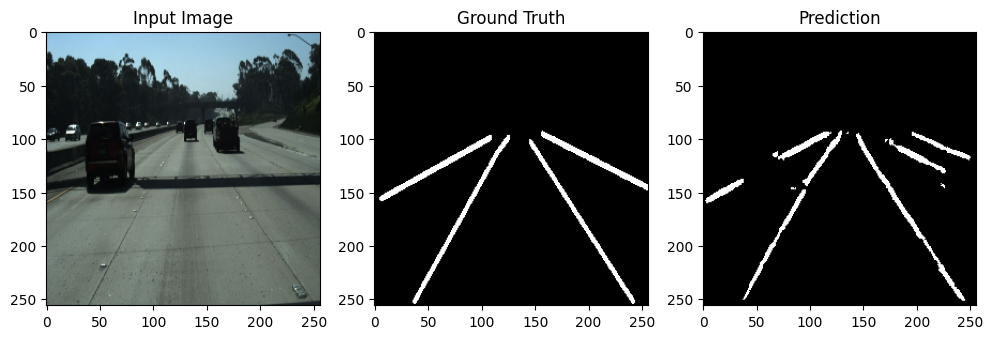

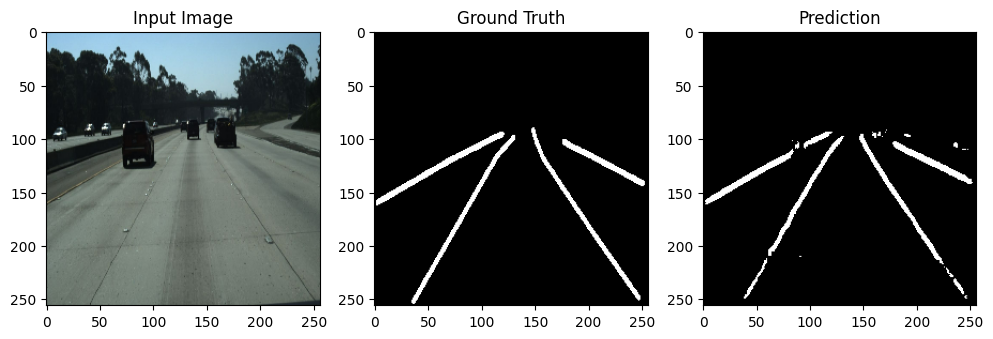

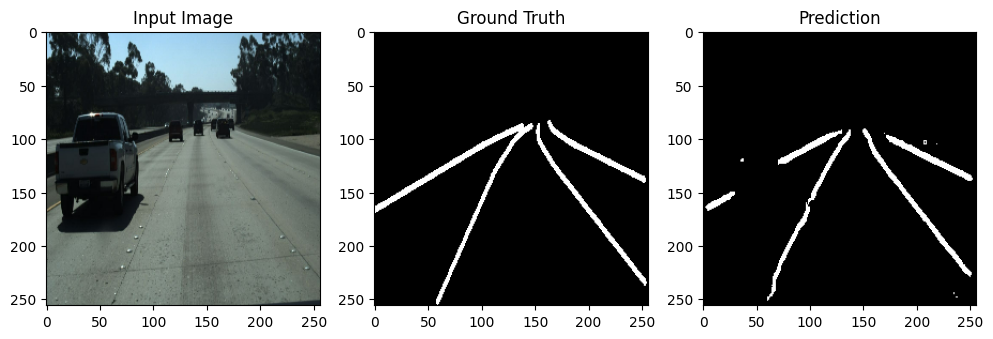

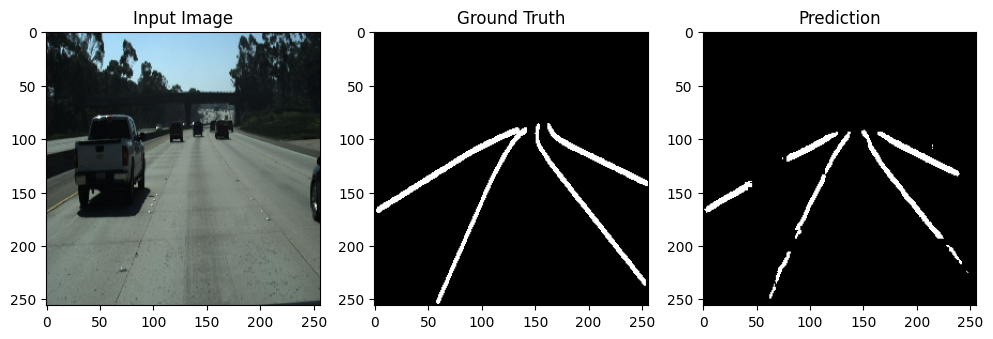

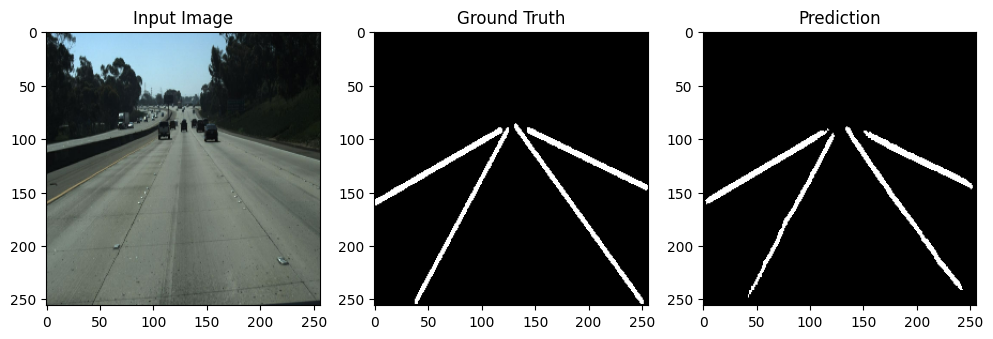

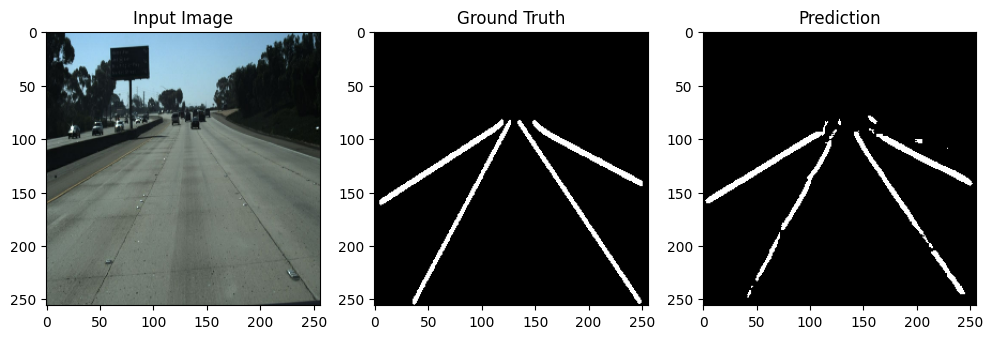

In [9]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_dataset):
    for images, masks in test_dataset.take(1):
        preds = model.predict(images)
        preds = (preds > 0.5).astype("uint8")

        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i])

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(preds[i].squeeze(), cmap="gray")
            plt.show()

visualize_predictions(model, val_dataset)

In [12]:
!pip install seaborn --quiet

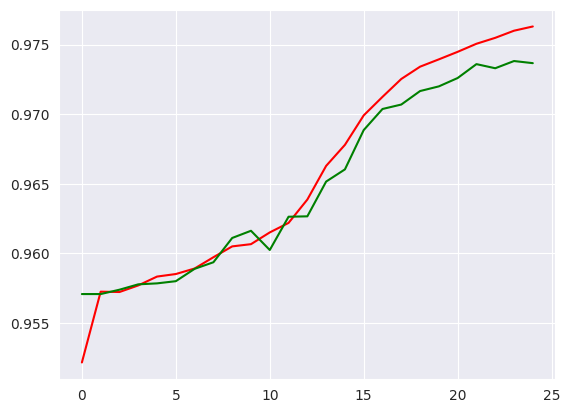

In [14]:
import seaborn as sns
sns.set_style('darkgrid')
plt.plot(h.history['accuracy'], color = 'red')
plt.plot(h.history['val_accuracy'], color = 'green')

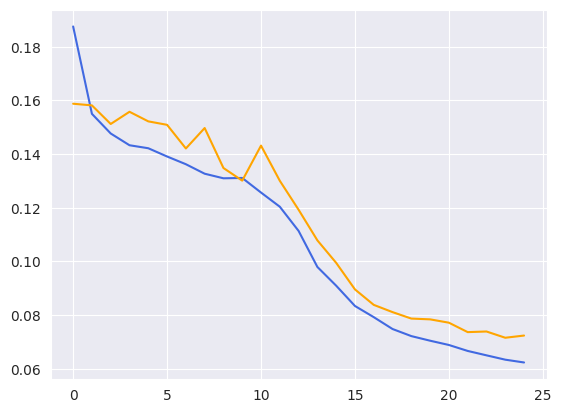

In [15]:
import seaborn as sns
sns.set_style('darkgrid')
plt.plot(h.history['loss'], color = 'royalblue')
plt.plot(h.history['val_loss'], color = 'orange')